##  Dataset
- **Source:** Kaggle
- **Features used:**
  - `Global_active_power` (main energy consumption variable)
  - Time-based features derived from the datetime index

---

In [50]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as mp
import seaborn as sns

In [51]:
#Load the dataset
data = pd.read_csv(
    "household_power_consumption.txt",
    sep=';', # values separated by ;
    na_values='?',          
    low_memory=False
)

In [52]:
data.columns = data.columns.str.strip()
# Combine Date and Time
data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
# Set DateTime as index
data.set_index('DateTime', inplace=True)
                    
data.dropna(inplace=True) # Drop rows with missing values
data = data.astype(float, errors='ignore') # Convert numeric columns to float

print(data.isnull().sum()) #Missing Values
data


C:\Users\hp\AppData\Local\Temp\ipykernel_31076\3840671286.py:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])


Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,,,
2006-12-16 17:24:00,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...,...,...
2010-11-26 20:58:00,26/11/2010,20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,26/11/2010,20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,26/11/2010,21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0


In [53]:
numeric_data = data.select_dtypes(include='number')
# Resample hourly
resample_data = numeric_data.resample('H').mean()
# Add time-based features
resample_data['hour'] = resample_data.index.hour
resample_data['day_of_week'] = resample_data.index.dayofweek
resample_data['is_weekend'] = (resample_data['day_of_week'] >= 5).astype(int)
#Forward fill missing values
resample_data = resample_data.ffill()



C:\Users\hp\AppData\Local\Temp\ipykernel_31076\2029503827.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resample_data = numeric_data.resample('H').mean()


In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from xgboost import XGBRegressor 
from statsmodels.tsa.arima.model import ARIMA 
from prophet import Prophet


In [55]:
# Splitting this way due to time series data
train_set = resampled.iloc[:-24*30] # all data except last 30 days
test_set = resampled.iloc[-24*30:] # last 30 days

In [56]:
# ARIMA Model

arim_model = ARIMA(train['Global_active_power'], order=(3,1,2)) 
arim_result = arim_model.fit() 
arim_forecast = arim_result.forecast(steps=len(test)) # Forecast for the next 24 hours

C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [57]:
#Prophet Model

proph_data = train[['Global_active_power']].reset_index() # reset index to include date information
proph_data.columns = ['ds', 'y'] # columns of dataset for prophet
proph_model = Prophet(daily_seasonality=True) 
proph_model.fit(proph_data) 
future_dates = proph_model.make_future_dataframe(periods=len(test), freq='H') 
forecast_proph = proph_model.predict(future_dates) # make prediction
proph_forecast = forecast_proph.set_index('ds').loc[test.index]['yhat'] # Extracting prophet forecasted values


12:19:55 - cmdstanpy - INFO - Chain [1] start processing
12:20:12 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\prophet\forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [58]:
full_features = ['hour', 'day_of_week', 'is_weekend',
                 'Voltage', 'Global_reactive_power',
                 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'] # all the features to be added in xgboost

X_train = train[full_features]
y_train = train['Global_active_power']
X_test = test[full_features]
y_test = test['Global_active_power']

xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test) # predictions


ARIMA Model - MAE => 0.66971470605443
ARIMA Model - RMSE => 0.8302944847387753
Prophet Model - MAE => 0.5605489829354688
Prophet Model - RMSE => 0.7270363158557125
XGBoost Model - MAE => 0.2341344041942888
XGBoost Model - RMSE => 0.34642840830612437


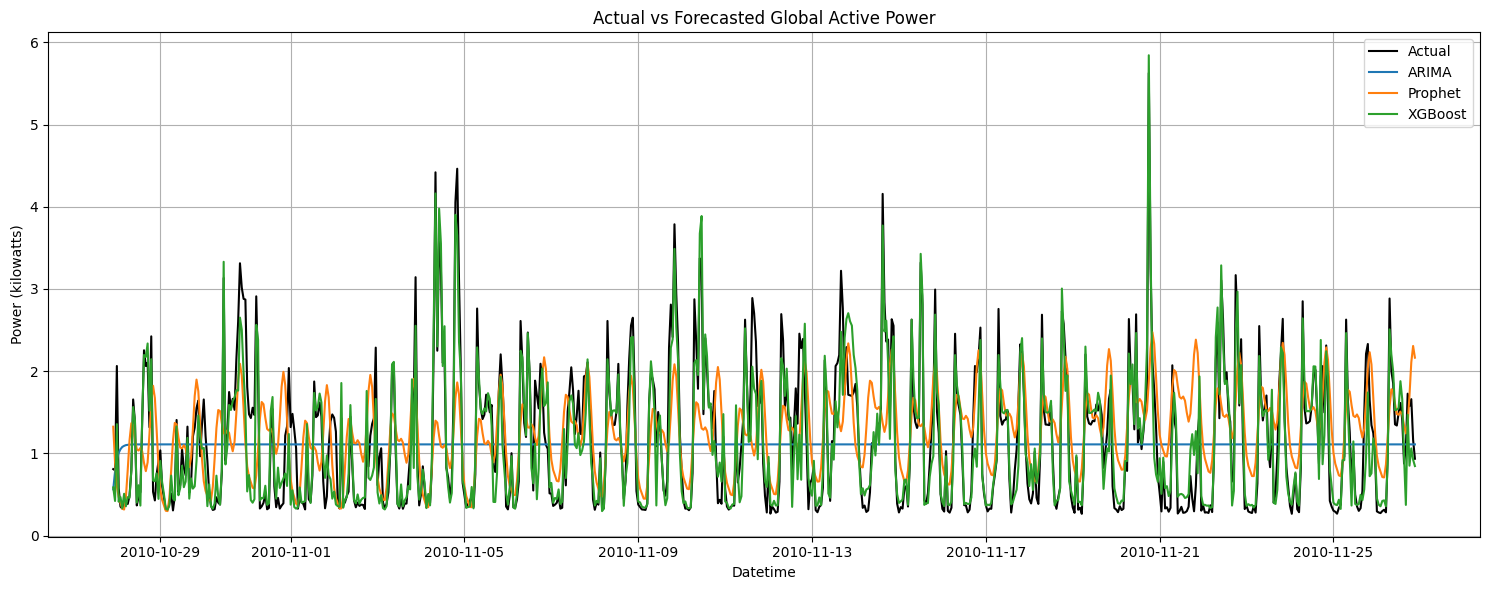

In [59]:
#Evaluation of each model

mae_arima = mean_absolute_error(test['Global_active_power'], arima_forecast) 
rmse_arima = np.sqrt(mean_squared_error(test['Global_active_power'], arima_forecast)) 
print("ARIMA Model - MAE =>", mae_arima) # Mean Absolute Error
print("ARIMA Model - RMSE =>", rmse_arima) # Root Mean Squared Error

mae_prophet = mean_absolute_error(test['Global_active_power'], prophet_forecast) 
rmse_prophet = np.sqrt(mean_squared_error(test['Global_active_power'], prophet_forecast)) 
print("Prophet Model - MAE =>", mae_prophet) # Mean Absolute Error
print("Prophet Model - RMSE =>", rmse_prophet)# Root Mean Squared Error

mae_xgb = mean_absolute_error(test['Global_active_power'], y_pred_xgb) 
rmse_xgb = np.sqrt(mean_squared_error(test['Global_active_power'], y_pred_xgb)) 
print("XGBoost Model - MAE =>", mae_xgb) # Mean Absolute Error
print("XGBoost Model - RMSE =>", rmse_xgb) # Root Mean Squared Error

#Plotting the results

mp.figure(figsize=(15, 6)) 
mp.plot(test_set.index, test['Global_active_power'], label='Actual', color='black') 
mp.plot(test_set.index, arim_forecast, label='ARIMA') 
mp.plot(test_set.index, proph_forecast, label='Prophet') 
mp.plot(test_set.index, y_pred_xgb, label='XGBoost') 
mp.title("Actual vs Forecasted Global Active Power") 
mp.xlabel("Datetime") 
mp.ylabel("Power (kilowatts)")
mp.legend() 
mp.grid(True) 
mp.tight_layout() 
mp.show()

## Conclusion:
- XGBoost significantly outperforms both ARIMA and Prophet in terms of MAE and RMSE.
- Prophet performs better than ARIMA, especially in handling seasonal patterns.
- ARIMA, while traditional, lags behind in accuracy for this dataset.
- Lower MAE and RMSE indicate XGBoost is best suited for short-term forecasting in this task.
